[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/drdave-teaching/OPIM5509Files/blob/main/OPIM5509_Module4_Files/b_Many_To_Many_BDL_tmpf_and_tmpfPlus1.ipynb)

# b_Many To Many (Numeric Sequences)
---------------------------------
**Dr. Dave Wanik - University of Connecticut**

[y is one variable, but predicting two timesteps into the future - NOT AUTOREGRESSIVE]

Let's read in the BDL data and see if we can predict two or three time steps into the future. We call this n_outputs or time steps into the future.

This script works by using the same LSTM cell, connecting to a dense layer, but the dense layer has hidden_units = n_outputs.

In [ ]:
# import modules
from numpy import array
from tensorflow.keras.preprocessing.text import one_hot
#from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
#from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.layers import Input
#from keras.layers.merge import Concatenate
from keras.layers import Bidirectional

import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt

In [ ]:
# # https://drive.google.com/file/d/1vhWT7__EDc-WQ7WGnK0RP2qq7-25LCWS/view?usp=sharing
# !gdown 1vhWT7__EDc-WQ7WGnK0RP2qq7-25LCWS
# # read the data
# df = pd.read_csv('cleanBDL.csv')

Downloading...
From: https://drive.google.com/uc?id=1vhWT7__EDc-WQ7WGnK0RP2qq7-25LCWS
To: /content/cleanBDL.csv
100% 4.40M/4.40M [00:00<00:00, 99.4MB/s]


In [ ]:
# Link to the data file on Github
url = "https://raw.githubusercontent.com/drdave-teaching/OPIM5509Files/refs/heads/main/OPIM5509_Module4_Files/cleanBDL.csv"

# retrieve the CSV data and build a dataframe
df = pd.read_csv(url)

df.shape

(46272, 10)

In [ ]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46272 entries, 0 to 46271
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   valid   46272 non-null  object 
 1   tmpf    46272 non-null  float64
 2   dwpf    46272 non-null  float64
 3   relh    46272 non-null  float64
 4   drct    46272 non-null  float64
 5   sknt    46272 non-null  float64
 6   p01i    46272 non-null  float64
 7   alti    46272 non-null  float64
 8   mslp    46272 non-null  float64
 9   vsby    46272 non-null  float64
dtypes: float64(9), object(1)
memory usage: 3.5+ MB


,valid,tmpf,dwpf,relh,drct,sknt,p01i,alti,mslp,vsby
0,2015-01-01 00:00:00,17.96,6.08,59.10,190.0,5.0,0.0,30.09,1019.0,10.0
1,2015-01-01 01:00:00,19.94,8.06,59.40,190.0,5.0,0.0,30.08,1018.7,10.0
2,2015-01-01 02:00:00,23.00,6.98,49.69,210.0,9.0,0.0,30.06,1018.1,10.0
3,2015-01-01 03:00:00,21.92,5.00,47.52,230.0,11.0,0.0,30.04,1017.4,10.0
4,2015-01-01 04:00:00,23.00,3.92,43.21,250.0,13.0,0.0,30.05,1017.7,10.0


# Define X and Y
If we are going to use our split sequences script from Brownlee, then we need to make sure our Y variables are on the end!

In [ ]:
# let's drop the valid column
# Y will be dwpf and relh
# X will be everything else!

del df['valid']
df.head() # check your work

,tmpf,dwpf,relh,drct,sknt,p01i,alti,mslp,vsby
0,17.96,6.08,59.10,190.0,5.0,0.0,30.09,1019.0,10.0
1,19.94,8.06,59.40,190.0,5.0,0.0,30.08,1018.7,10.0
2,23.00,6.98,49.69,210.0,9.0,0.0,30.06,1018.1,10.0
3,21.92,5.00,47.52,230.0,11.0,0.0,30.04,1017.4,10.0
4,23.00,3.92,43.21,250.0,13.0,0.0,30.05,1017.7,10.0


In [ ]:
Y = df[['tmpf']]
X = df.drop(axis=1, columns=['tmpf'])
print(df.shape, X.shape, Y.shape)

# looks good! Let's prepare samples for modeling

(46272, 9) (46272, 8) (46272, 1)


In [ ]:
# put Y all the way on the left
df = pd.concat([X, Y], axis=1, sort=False)
df.head(n=11)

,dwpf,relh,drct,sknt,p01i,alti,mslp,vsby,tmpf
0,6.08,59.10,190.0,5.0,0.0,30.09,1019.0,10.0,17.96
1,8.06,59.40,190.0,5.0,0.0,30.08,1018.7,10.0,19.94
2,6.98,49.69,210.0,9.0,0.0,30.06,1018.1,10.0,23.00
3,5.00,47.52,230.0,11.0,0.0,30.04,1017.4,10.0,21.92
4,3.92,43.21,250.0,13.0,0.0,30.05,1017.7,10.0,23.00
5,3.92,43.21,250.0,11.0,0.0,30.06,1018.1,10.0,23.00
6,3.02,41.45,240.0,13.0,0.0,30.07,1018.4,10.0,23.00
7,3.92,41.30,240.0,11.0,0.0,30.08,1018.9,10.0,24.08
8,3.92,38.03,210.0,8.0,0.0,30.08,1018.9,10.0,26.06
9,3.92,35.05,220.0,14.0,0.0,30.08,1018.8,10.0,28.04


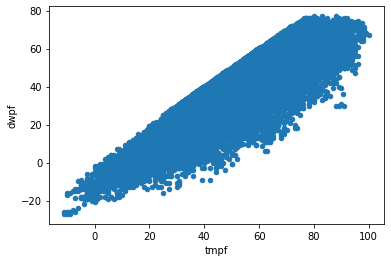

In [ ]:
# some eda - we should be able to predict temperature!
df.plot.scatter(x='tmpf', y='dwpf')
plt.show()

In [ ]:
# to get our other code to run, we will put Y
# on the end then re-run our code (needs updating from blog)

# prep data for modeling (multivariate)
# link: https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

from numpy import array

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in np.arange(len(sequences)): # be careful of this line!
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
    # X and Y have been UPDATED so the last two columns drop off
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1:]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

# Prepare Samples for Modeling
Everything needs to be in 3D arrays.

In [ ]:
# let's turn X into lookbacks of 10 with all of our samples
# all we need to do is decide on is n_steps (what our lookback period is)
# since we have a bunch of data, why not n_steps=10? then try 30 later on.
n_steps = 10
raw_seq = np.array(df) #make sure your data is stored as a numpy array!
# let's ignore the date column and just use the temperature data
X, y = split_sequences(raw_seq, n_steps=10)

In [ ]:
# check your work
print(df.shape, X.shape, y.shape)

(46272, 9) (46263, 10, 8) (46263, 1)


In [ ]:
# here's the first X
X[0]

array([[   6.08,   59.1 ,  190.  ,    5.  ,    0.  ,   30.09, 1019.  ,
          10.  ],
       [   8.06,   59.4 ,  190.  ,    5.  ,    0.  ,   30.08, 1018.7 ,
          10.  ],
       [   6.98,   49.69,  210.  ,    9.  ,    0.  ,   30.06, 1018.1 ,
          10.  ],
       [   5.  ,   47.52,  230.  ,   11.  ,    0.  ,   30.04, 1017.4 ,
          10.  ],
       [   3.92,   43.21,  250.  ,   13.  ,    0.  ,   30.05, 1017.7 ,
          10.  ],
       [   3.92,   43.21,  250.  ,   11.  ,    0.  ,   30.06, 1018.1 ,
          10.  ],
       [   3.02,   41.45,  240.  ,   13.  ,    0.  ,   30.07, 1018.4 ,
          10.  ],
       [   3.92,   41.3 ,  240.  ,   11.  ,    0.  ,   30.08, 1018.9 ,
          10.  ],
       [   3.92,   38.03,  210.  ,    8.  ,    0.  ,   30.08, 1018.9 ,
          10.  ],
       [   3.92,   35.05,  220.  ,   14.  ,    0.  ,   30.08, 1018.8 ,
          10.  ]])

In [ ]:
# here's the first Y
y[0]

# go scroll up and make sure this matches!
# and it does!

# you will need to customize your split script when
# prepping your data... be careful! take control of your data!

array([28.04])

## Y, Y+1 and Y+2
Let's make sure that our Y vector has multiple time steps, just like we did in the previous script.

In [ ]:
# convert to a dataframe
tmp = pd.DataFrame(y)
# rename the column
tmp.rename(columns={0:'y'}, inplace=True)
# create some shifts
tmp['yPlus1'] = tmp['y'].shift(-1)
tmp['yPlus2'] = tmp['y'].shift(-2)
# check your work
print(tmp.head())
print(tmp.tail()) # we will have to deal with those NaN's

# either ffill them or delete them later.

       y  yPlus1  yPlus2
0  28.04   30.02   32.00
1  30.02   32.00   33.08
2  32.00   33.08   33.98
3  33.08   33.98   33.08
4  33.98   33.08   33.08
          y  yPlus1  yPlus2
46258  44.1    42.1    39.0
46259  42.1    39.0    39.9
46260  39.0    39.9    37.0
46261  39.9    37.0     NaN
46262  37.0     NaN     NaN


In [ ]:
# I will opt to forward fill them
# and just except the dirt in my data
tmp.fillna(method='ffill', inplace=True)
tmp.tail() # all better!

# of course, you could have dropped the last N arrays
# from both X and y (making sure the shape matches up)

,y,yPlus1,yPlus2
46258,44.1,42.1,39.0
46259,42.1,39.0,39.9
46260,39.0,39.9,37.0
46261,39.9,37.0,37.0
46262,37.0,37.0,37.0


In [ ]:
# convert back to numpy array
y = tmp

In [ ]:
y.shape

(46263, 3)

# Fit a Model
This will be similar to the last example in 'Sequence Problems_Pt1.ipynb'

In [ ]:
# note how there's a 2 at the end
# usually we did this for a multi-classification problem, but not today!
# by default, it's a 'linear' activiation function
# so this is 2 node output and we're doing regression.

n_steps = X.shape[1]
n_features = X.shape[2]
n_outputs = y.shape[1]

print(n_steps, n_features, n_outputs)

10 8 3


In [ ]:
model = Sequential()
model.add(LSTM(50, activation='relu',
               recurrent_dropout=0.1,
               input_shape=(n_steps, n_features)))
model.add(Dropout(0.2))
model.add(Dense(n_outputs)) # since Y has three values, we need to predict three values
model.compile(optimizer='adam', loss='mse')

import keras
from keras.callbacks import EarlyStopping

# early stopping callback
# This callback will stop the training when there is no improvement in
# the validation loss for 10 consecutive epochs.
es = keras.callbacks.EarlyStopping(monitor='val_loss',
                                   mode='min',
                                   patience=10, # you can play with this!
                                   restore_best_weights=True) # important - otherwise you just return the last weigths...

# now we just update our model fit call
history = model.fit(X,
                    y,
                    callbacks=[es],
                    epochs=800, # you can set this to a big number!
                    batch_size=100,
                    validation_split=0.2,
                    verbose=1,
                    shuffle=True)

Epoch 1/800
371/371 [==============================] - 17s 31ms/step - loss: 8392.0361 - val_loss: 346.3491
Epoch 2/800
371/371 [==============================] - 7s 19ms/step - loss: 589.6161 - val_loss: 139.8673
Epoch 3/800
371/371 [==============================] - 7s 19ms/step - loss: 338.7454 - val_loss: 97.0023
Epoch 4/800
371/371 [==============================] - 7s 18ms/step - loss: 296.4155 - val_loss: 74.6774
Epoch 5/800
371/371 [==============================] - 7s 19ms/step - loss: 276.7203 - val_loss: 74.9903
Epoch 6/800
371/371 [==============================] - 9s 24ms/step - loss: 259.8274 - val_loss: 75.1838
Epoch 7/800
371/371 [==============================] - 10s 27ms/step - loss: 242.5056 - val_loss: 62.4302
Epoch 8/800
371/371 [==============================] - 8s 23ms/step - loss: 216.2087 - val_loss: 65.4773
Epoch 9/800
371/371 [==============================] - 7s 19ms/step - loss: 213.7571 - val_loss: 49.9869
Epoch 10/800
371/371 [============================

In [ ]:
# and you can show how your model did

# since it's a single sample, we need to reshape
data = X[0]
data = data.reshape(1,n_steps,n_features)
print(data)
print(model.predict(data))

# did we get close?
print(y[0:1])

# of course you can show scatterplots and everything else
# for more examples

[[[   6.08   59.1   190.      5.      0.     30.09 1019.     10.  ]
  [   8.06   59.4   190.      5.      0.     30.08 1018.7    10.  ]
  [   6.98   49.69  210.      9.      0.     30.06 1018.1    10.  ]
  [   5.     47.52  230.     11.      0.     30.04 1017.4    10.  ]
  [   3.92   43.21  250.     13.      0.     30.05 1017.7    10.  ]
  [   3.92   43.21  250.     11.      0.     30.06 1018.1    10.  ]
  [   3.02   41.45  240.     13.      0.     30.07 1018.4    10.  ]
  [   3.92   41.3   240.     11.      0.     30.08 1018.9    10.  ]
  [   3.92   38.03  210.      8.      0.     30.08 1018.9    10.  ]
  [   3.92   35.05  220.     14.      0.     30.08 1018.8    10.  ]]]
1/1 [==============================] - 0s 297ms/step
[[28.148977 28.730747 27.977386]]
       y  yPlus1  yPlus2
0  28.04   30.02    32.0


In [ ]:
# select first column of y
y['y']

0        28.04
1        30.02
2        32.00
3        33.08
4        33.98
         ...  
46258    44.10
46259    42.10
46260    39.00
46261    39.90
46262    37.00
Name: y, Length: 46263, dtype: float64

In [ ]:
# well done! You can also make scatterplots of actual vs. predicted
pred = model.predict(X)
pred

1446/1446 [==============================] - 5s 3ms/step


array([[28.148977, 28.730747, 27.977386],
       [29.65662 , 30.185104, 29.40461 ],
       [30.89119 , 31.36789 , 30.543953],
       ...,
       [38.68242 , 38.847694, 37.96832 ],
       [39.480103, 39.67096 , 38.84119 ],
       [37.18184 , 37.425407, 36.633003]], dtype=float32)

In [ ]:
# select first column
pred[:,0:1]

array([[28.148977],
       [29.65662 ],
       [30.89119 ],
       ...,
       [38.68242 ],
       [39.480103],
       [37.18184 ]], dtype=float32)

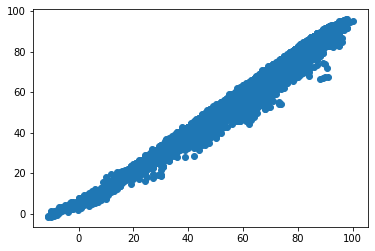

In [ ]:
# pred1
plt.scatter(y['y'], pred[:,0:1])
plt.show()

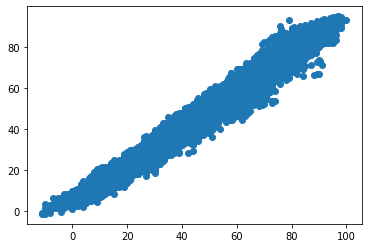

In [ ]:
# pred2
plt.scatter(y['yPlus1'], pred[:,1:2])
plt.show()

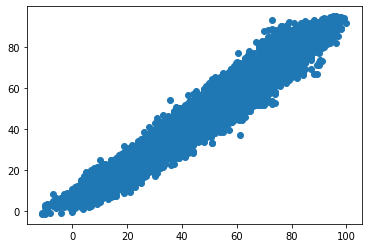

In [ ]:
# and the third one
plt.scatter(y['yPlus2'], pred[:,1:2])
plt.show()

In [ ]:
# it worked! of course the prediction into the
# future will be a little worst than the next time step

# and as you can see, prepping the data is important!